In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms import smallworld
import random
from collections import Counter
from scipy.spatial import cKDTree

In [3]:
from src.neuron_population import NeuronPopulation
from src.connectome import Connectome
from src.overhead import Simulation
from src.neuron_templates import neuron_type_IZ
from src.network_grower import *
from src.network_generators import *
from src.neuron_type_distributor import *
from src.network_weight_distributor import *
from src.external_inputs import *

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv("cmaes_analysis3/cmaes_trials.csv")

In [7]:
# Find columns starting with "param" for the row with the highest "score"
max_score_row = df.loc[df['score'].idxmax()]
param_columns = max_score_row.filter(like='param')
print(param_columns)

param.A_AMPA                            0.196566
param.A_GABA_A                          0.000106
param.A_GABA_B                          0.000103
param.A_NMDA                            0.011642
param.external_amplitude                2.446255
param.g_AMPA_max                      943.876702
param.g_GABA_A_max                    477.112848
param.g_GABA_B_max                    978.238646
param.g_NMDA_max                     1132.461381
param.inhibitory_nmda_weight            0.959686
param.inhibitory_scale_g                1.298475
param.recurrent_exc_lognorm_sigma       1.643570
param.v_ext                             0.455270
Name: 3641, dtype: float64


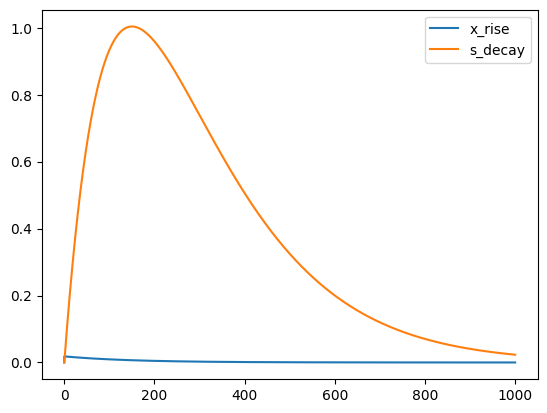

In [494]:
ts = np.arange(0, 1000, 0.1)  # time steps in ms

xs = np.zeros_like(ts)
ss = np.zeros_like(ts)

x_decay = np.exp(-0.1 / 150)  # tau = 50 ms
s_decay = np.exp(-0.1 / 150)  # tau = 150 ms

spikes = np.zeros_like(ts)
spikes[1] = 1.0/55  # spike at the middle
# spikes[1000] = 1.0/20  # spike at the middle

for t in range(1, len(ts)//2):
    xs[t] = x_decay * xs[t-1]
    ss[t] = s_decay * ss[t-1]
    ss[t] += xs[t-1] * 0.1
    xs[t] += spikes[t]
    # ss[t] += spikes[t]

for t in range(len(ts)//2, len(ts)):
    xs[t] = x_decay * xs[t-1]
    ss[t] = s_decay * ss[t-1]
    ss[t] += xs[t-1] * 0.1
    xs[t] += spikes[t]
    # ss[t] += spikes[t]

plt.plot(ts, xs, label='x_rise')
plt.plot(ts, ss, label='s_decay')
plt.legend()
plt.show()

In [495]:
weight_scale = 1.0
g = 1.0

J_I = weight_scale * g
J_E = weight_scale
delay_mean = 1.5
delay_std = delay_mean * 0.2
v_ext = 0.1

excitatory_type = "ss4"
inhibitory_type = "b"

## Generate network

In [496]:
G = nx.DiGraph()

n_neurons = 12
n_excitatory = 12

# Add 1000 nodes
for i in range(n_neurons):
    G.add_node(i)

# Assign 800 nodes as excitatory and 200 as inhibitory
# excitatory_nodes = random.sample(range(n_neurons), 800)
for i in range(n_excitatory):
        G.nodes[i]['inhibitory'] = False
        G.nodes[i]['ntype'] = excitatory_type
        G.nodes[i]['layer'] = 0

for i in range(n_excitatory, n_neurons):
        G.nodes[i]['inhibitory'] = True
        G.nodes[i]['ntype'] = inhibitory_type
        G.nodes[i]['layer'] = 0

# For each node, draw m outgoing edges to random nodes
# n_out = 1
# for i in range(n_neurons):
#     targets = random.sample(range(n_neurons), n_out)
#     for target in targets:
#         if G.nodes[i]['inhibitory']:
#             weight = J_I
#         else:
#             weight = J_E
#         delay = max(0.1, np.random.normal(delay_mean, delay_std))
#         G.add_edge(i, target, weight=weight, distance=delay)

for i in range(n_neurons-1):
        G.add_edge(i, 11, weight=J_E, distance=1.5)

In [497]:
# Redistribute lognormally
# G = assign_lognormal_weights_for_ntype(G, "ss4", mu=0.5, sigma=0.5, w_max=10.0)

Text(0.5, 1.0, 'ss4 Weight Distribution after Lognormal Redistribution')

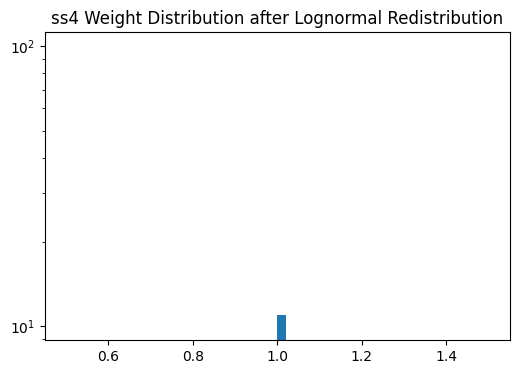

In [498]:
# Plot ss4 weight distribution
weights = [G[u][v]['weight'] for u, v in G.edges() if G.nodes[u]['ntype'] == 'ss4']
plt.figure(figsize=(6,4))
plt.hist(weights, bins=50, log=True)
plt.title("ss4 Weight Distribution after Lognormal Redistribution")

## Simulation setup

In [499]:
dt = 0.1

In [500]:
# Neuron population parameters
n_neurons = G.number_of_nodes()
neuron_types = [excitatory_type, inhibitory_type]
n_neuron_types = len(neuron_types)
inhibitory = [False, True]
threshold_decay = np.exp(-dt / 5)

pop = NeuronPopulation(n_neurons, neuron_types, inhibitory, threshold_decay)

In [501]:
# Connectome
# Max number of outgoing synapses per neuron
max_synapses = max(dict(G.out_degree()).values())

connectome = Connectome(max_synapses, pop)

connectome.nx_to_connectome(G)

## Simulation

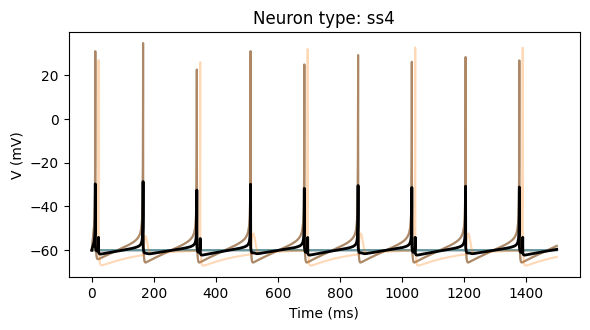

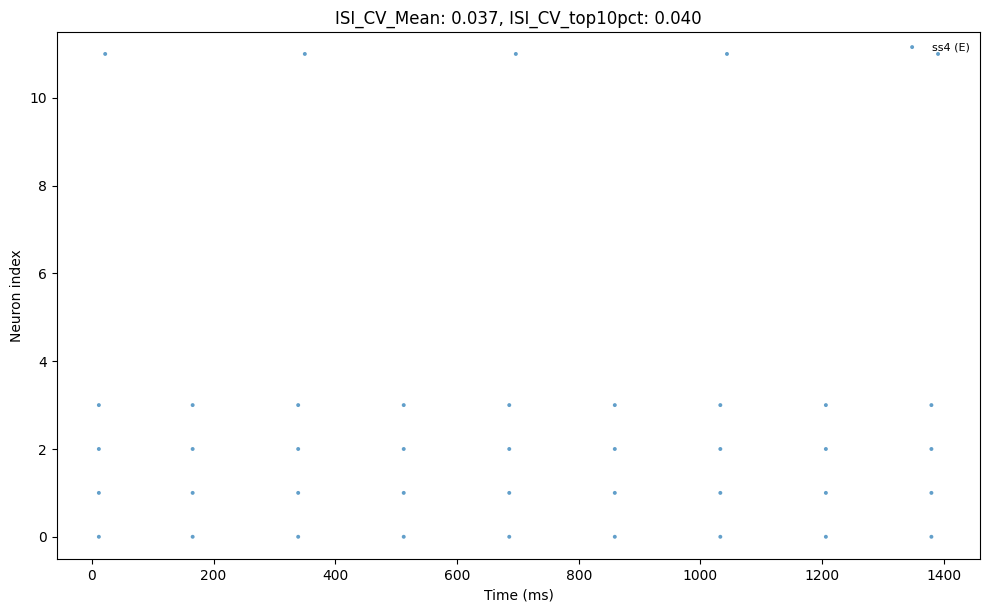

In [502]:

# Randomize initial voltages
Vs = np.random.uniform(-60, -60, size=n_neurons)
us = np.random.uniform(0, 400, size=n_neurons) * 0
spikes = np.zeros(n_neurons, dtype=bool)
Ts = np.zeros_like(spikes)

state0 = (Vs,
          us,
          spikes.copy(),
          Ts.copy())

# sim = Simulation(connectome, dt, stepper_type="simple", state0=state0,
#                  enable_plasticity=False)
sim = Simulation(connectome, dt, stepper_type="euler_det", state0=state0,
                 enable_plasticity=False, synapse_kwargs={"LT_scale": 1.0},
                 rise_synapse=False)

rate = np.zeros(n_neurons)
rate[:4] = 200
poisson = PoissonInput(n_neurons, rate=v_ext, amplitude=10.0)

for i in range(15000):
    sensory_spikes = poisson(dt)
    sensory_spikes[11] = 0.0
    # sim.step(spike_ext=sensory_spikes)
    sim.step(I_ext=rate)


sim.plot_voltage_per_type(figsize=(6, 6))

stats = sim.stats.compute_metrics(dt, bin_ms_participation=300)

isi_mean = stats['ISI_CV_mean']
isi_top = stats["ISI_CV_mean_top10pct"]

sim.plot_spike_raster(figsize=(10, 6), title=f"ISI_CV_Mean: {isi_mean:.3f}, ISI_CV_top10pct: {isi_top:.3f}", t_start_ms=0.0, t_stop_ms=3000.0)

In [503]:
sim.stats.compute_metrics(dt, bin_ms_participation=300, t_start_ms=1000.0, t_stop_ms=3000.0)

{'rate_mean_Hz': 2.332866759981337,
 'rate_median_Hz': 0.0,
 'rate_p95_Hz': 5.9988002399520095,
 'ISI_CV_median': 0.0,
 'ISI_CV_mean': 0.0,
 'ISI_CV_mean_E': 0.0,
 'ISI_CV_mean_I': 0.0,
 'ISI_CV_mean_top10pct': 0.0,
 'refractory_violations_per_neuron': 0.0,
 'Fano_median_2ms': 0.9919678714859455,
 'Fano_median_10ms': 0.9591836734693885,
 'Fano_median_50ms': 0.7777777777777777,
 'Fano_median_100ms': 0.5000000000000001,
 'Fano_median_300ms': 0.0,
 'Fano_median_500ms': 0.0,
 'Fano_median_1000ms': 0.0,
 'mean_noise_corr_2ms': 0.09030927419397405,
 'mean_noise_corr_10ms': 0.08778357124455204,
 'mean_noise_corr_50ms': 0.1371977336789917,
 'mean_noise_corr_100ms': 0.13131313077704768,
 'mean_noise_corr_300ms': 0.0,
 'mean_noise_corr_500ms': 0.0,
 'mean_noise_corr_1000ms': 0.0,
 'participation_frac_mean_300ms': 0.4166666666666667,
 'participation_frac_median_300ms': 0.4166666666666667,
 'participation_frac_p95_300ms': 0.4166666666666667,
 'participation_frac_total': 0.4166666666666667,
 'pop_s

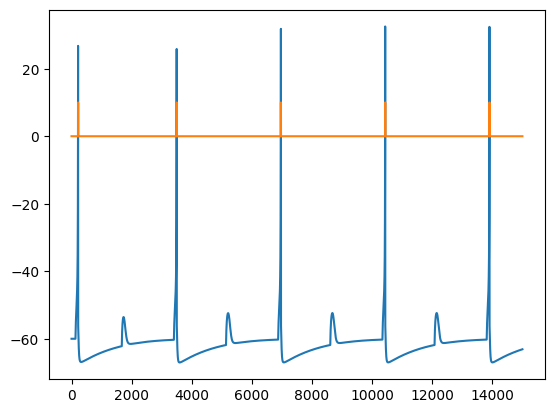

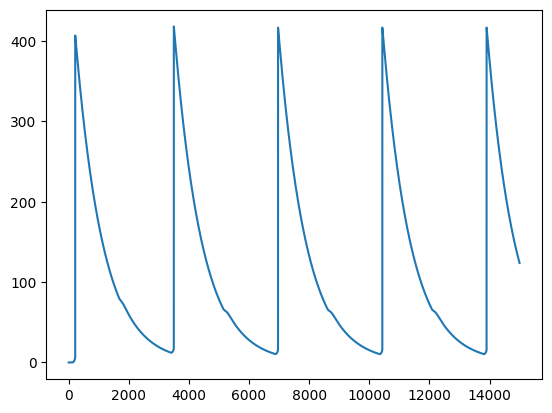

Max V - Min V: 99.54410913666956


In [504]:
# Plot spikes for one neuron
n_idx = 11
t_first = 0
t_last = -1
plt.plot(np.array(sim.stats.Vs)[t_first:t_last,n_idx])
plt.plot(np.array(sim.stats.spikes)[t_first:t_last,n_idx] * 10)
plt.show()
plt.plot(np.array(sim.stats.us)[t_first:t_last,n_idx])
plt.show()
# Max V - min V
print("Max V - Min V:", np.max(np.array(sim.stats.Vs)[:,n_idx]) - np.min(np.array(sim.stats.Vs)[:,n_idx]))

In [505]:
# connectome.compute_metrics(small_world=False)